In [1]:
from torch import nn
from torchvision import models 
from torchvision import transforms as T 
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
import torch
import numpy as np 
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader, SubsetRandomSampler

In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [3]:
data_transforms = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
dataset = ImageFolder(root='images', transform=data_transforms)
dataset.classes = [int(i) for i in dataset.classes]
for (_, (img, _)) in enumerate(dataset):
    img = img.unsqueeze(0)

In [4]:
dataset_size = len(dataset)
dataset_indices = list(range(dataset_size))
test_split_indices = int(np.floor(0.2 * dataset_size))
train_indices  = dataset_indices[test_split_indices:]
test_indices = dataset_indices[:test_split_indices]

In [5]:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
train_loader = DataLoader(dataset=dataset, shuffle = False, batch_size=16, sampler=train_sampler, num_workers=2)
test_loader = DataLoader(dataset=dataset, shuffle = False, batch_size=16, sampler=test_sampler, num_workers=2)

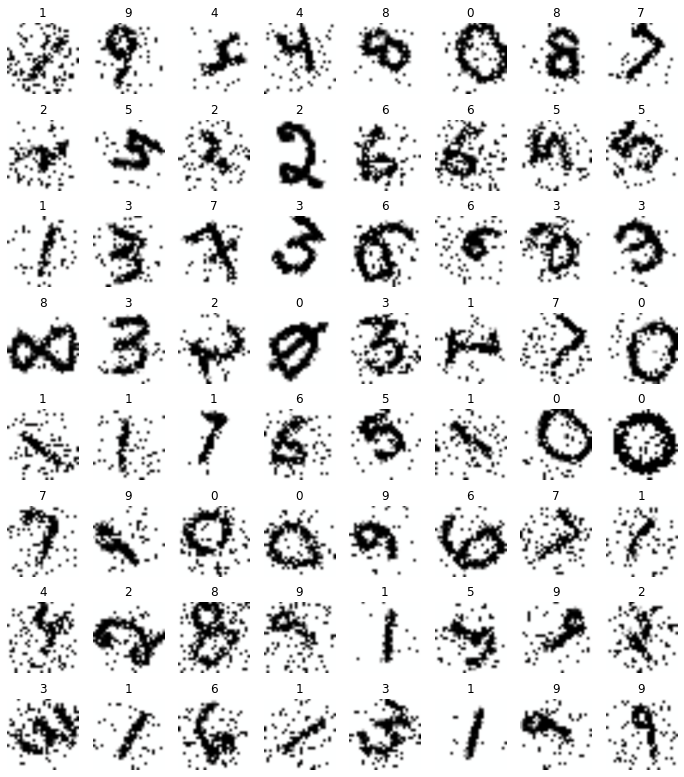

In [9]:
figure = plt.figure(figsize=(12, 12), linewidth=10)
cols, rows = 8, 8

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_loader.dataset), size=(1,)).item()
    img, label = train_loader.dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img, cmap='gray')

plt.subplots_adjust(top=1.)    
plt.show()

In [10]:
# create network
net = models.vgg16(pretrained=True)
for param in net.parameters():
    param.requires_grad = False
    
net.classifier[6] = nn.Sequential(nn.Linear(4096, 1000),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5),
                                        nn.Linear(1000, 10))
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
writer = SummaryWriter()

In [11]:
len(train_loader.dataset)

53700

In [ ]:
for epoch in range(25):
    
    avg_loss = 0.0
    total_correct = 0
    
    # set network to training mode
    net.train()
    print(f"epoch:  {epoch + 1}")
      
    for i, data in enumerate(train_loader):
        
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        # clear the gradients 
        optimizer.zero_grad()
        
        # forward pass
        outputs = net(images)
        
        # compute loss
        loss = criterion(outputs, labels)
        
        # backpropagation step
        loss.backward()
       
        # update parameters
        optimizer.step()
        _, predictions = torch.max(outputs.data, 1)
        torch.sum(predictions == labels)
        avg_loss = loss.item() / len(train_loader.dataset)
        total_correct += torch.sum(predictions == labels)
        lr_scheduler.step()
    
    writer.add_scalar("Train Loss", avg_loss / len(train_loader.dataset), epoch)
    writer.add_scalar("Train Accuracy", 100 * (total_correct / len(train_loader.dataset)), epoch)

In [13]:
torch.save(net.state_dict(), "model(3-22-22).pth")

In [42]:
# create network
net = models.vgg16(pretrained=True)
net.classifier[6] = nn.Sequential(nn.Linear(4096, 1000),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5),
                                        nn.Linear(1000, 10))
net.load_state_dict(torch.load("./model(3-22-22).pth"))
net = net.to(device)